In [41]:
!pip install z3-solver

In [42]:
from z3 import *

In [43]:
x = Int('x')
y = Int('y')
solve(x > 2, y < 10, x + 2*y == 7)

[y = 0, x = 7]


In [44]:
p = Bool("p")
my_true_thm = Implies(p, p)
my_true_thm

Implies(p, p)

In [45]:
prove(my_true_thm)

proved


In [46]:
#not ( P or Q) implies (not P) and (not Q)
p, q = Bools('p q')
lhs = Not(Or(p,q))
rhs = And(Not(p), Not(q))
my_true_thm = Implies( lhs, rhs )
print(my_true_thm)
proof = prove(my_true_thm)

Implies(Not(Or(p, q)), And(Not(p), Not(q)))
proved


In [47]:
my_true_thm.children(), prove(my_true_thm)

proved


([Not(Or(p, q)), And(Not(p), Not(q))], None)

In [48]:

x, y = Reals('x y')
g  = Goal()
g.add(x > 0, y > 0, x == y + 2)
print(g)

t1 = Tactic('simplify')
t2 = Tactic('solve-eqs')
t  = Then(t1, t2)
print(t(g))

[x > 0, y > 0, x == y + 2]
[[Not(y <= -2), Not(y <= 0)]]


In [49]:
p, q = Bools('p q')
lhs = Not(Or(p,q))
rhs = And(Not(p), Not(q))
print(lhs, rhs.sexpr())
my_true_thm = Implies( lhs, rhs )
print(my_true_thm.sexpr())
proof = prove(my_true_thm)

Not(Or(p, q)) (and (not p) (not q))
(=> (not (or p q)) (and (not p) (not q)))
proved


In [50]:
for i in range(0,my_true_thm.num_args()):
  print(my_true_thm.arg(i), my_true_thm.arg(i).decl(), my_true_thm.sexpr(), my_true_thm.params())

Not(Or(p, q)) Not (=> (not (or p q)) (and (not p) (not q))) []
And(Not(p), Not(q)) And (=> (not (or p q)) (and (not p) (not q))) []


In [51]:
my_true_thm

Implies(Not(Or(p, q)), And(Not(p), Not(q)))

In [52]:
p, q = Bools('p q')
lhs = Not(And(p,q))
rhs = Or(Not(p), Not(q))
print(lhs, rhs.sexpr())
my_true_thm = Implies( lhs, rhs )
print(my_true_thm.sexpr())
proof = prove(my_true_thm)

Not(And(p, q)) (or (not p) (not q))
(=> (not (and p q)) (or (not p) (not q)))
proved


In [53]:
my_true_thm

Implies(Not(And(p, q)), Or(Not(p), Not(q)))

In [54]:
Implies(Not(And(p,q)), Or(Not(p), Not(q))).children()

[Not(And(p, q)), Or(Not(p), Not(q))]

In [55]:
lhs

Not(And(p, q))

In [56]:
p, q = Bools('p q')
demorgan = And(p, q) == Not(Or(Not(p), Not(q)))
print(demorgan)

def prove(f):
    s = Solver()
    s.add(Not(f))
    if s.check() == unsat:
        print("proved")
    else:
        print("failed to prove")

print("Proving demorgan...")
prove(demorgan)

And(p, q) == Not(Or(Not(p), Not(q)))
Proving demorgan...
proved


In [57]:
demorgan

And(p, q) == Not(Or(Not(p), Not(q)))

In [58]:
print(demorgan)

And(p, q) == Not(Or(Not(p), Not(q)))


In [59]:
Implies( lhs, rhs )

Implies(Not(And(p, q)), Or(Not(p), Not(q)))

In [60]:
Not(Or(p,q))

Not(Or(p, q))

In [61]:
#not ( P or Q) implies (not P) and (not Q)
p, q = Bools('p q')
my_true_thm = Implies( Not(Or(p,q)), And(Not(p), Not(q)) )
proof = prove(my_true_thm)

proved


In [62]:
my_true_thm, proof

(Implies(Not(Or(p, q)), And(Not(p), Not(q))), None)

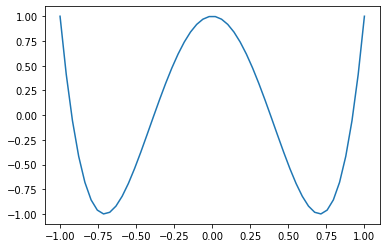

50

In [63]:
import sympy as sy
import matplotlib.pyplot as plt
import numpy as np
x = sy.symbols('x')
cheb = sy.lambdify(x, sy.chebyshevt(4,x))
xs = np.linspace(-1,1,50)
ys = cheb(xs)
plt.plot(xs, ys)
plt.show()
len(xs)

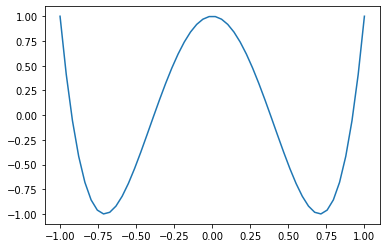

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def poly(x):
    return 8 * x ** 4 - 8 * x**2 + 1
xs = np.linspace(-1,1,50)
ys = poly(xs)
plt.plot(xs, ys)
plt.show()

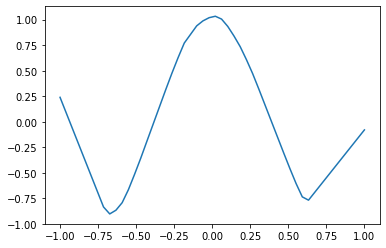

In [65]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

model = keras.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=[1]),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.fit(xs, ys, epochs=500, verbose=0)
plt.plot(xs,model.predict(xs))
plt.show()

In [66]:
w1, b1, w2, b2, w3, b3 = model.get_weights() # unpack weights from model

def Relu(x):
    return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)

# reinterpret network symbolically using z3 variables.
def net(x):
    x1 = w1.T @ x + b1
    y1 = Relu(x1)
    x2 = w2.T @ y1 + b2
    y2 = Relu(x2)
    x3 = w3.T @ y2 + b3
    return x3

x = np.array([Real('x')])
y_true = poly(x)
y_pred = net(x)
s = Solver()
s.add(-1 <= x[0], x[0] <= 1) # constraint input to [-1,1] interval

def Abs(x):
    return If(x <= 0, -x, x)
s.add(Abs( y_pred[0] - y_true[0] ) >= 0.5) # Is there an input with absolute error greater than 0.5?

res = s.check()
print(res)
if res == sat:
    m = s.model()
    print("Bad x value:", m[x[0]])
    x_bad = m[x[0]].numerator_as_long() / m[x[0]].denominator_as_long() 
    print("Error of prediction: ", abs(model.predict(np.array([x_bad])) - cheb(x_bad)))

sat
Bad x value: -63/64
Error of prediction:  [[0.57952476]]


In [67]:
def refactor_steps(res, formula):
    presteps = res[1:len(res)-1]
    print(presteps)
    steps = []
    for ss in presteps:
        a = ss.replace("$","").split(" ")
        for i,b in enumerate(a):
            if b.startswith("((x"):
                a[i] = b.replace("((x","x")+"="
            if b.startswith("(let"):
                a[i] = b.replace("(let","let")
            if b.startswith("(declare-fun"):
                a[i] = b.replace("(declare-fun","Declare function")
            if b.endswith("))"):
                a[i] = b.replace("))","")
            if "()" in b:
                a[i] = b.replace("()","")
        #r.append(s.replace)
        steps.append(" ".join(a[1:]))
    
    result_steps = [
        {"name":formula, "parent":""},
        {"name":"Declare", "parent":formula},
        {"name":"Axioms", "parent":"Declare"}, 
        {"name":"Proof","parent":"Axioms"},
    ]

    for s in steps:
        
        if "Bool" in s:
            this_step = s.strip().replace("$","")
            result_steps.append({"name":this_step, "parent":"Declare"})
        if s.startswith("let"):
            this_step = s.strip().replace("$","")
            result_steps.append({"name":this_step,"parent":"Axioms"}) 
        if s.startswith("(not"):
            this_step = s.strip().replace("$","").replace(")","",6)
            result_steps.append({"name":this_step, "parent":"Proof"}) 

    return result_steps


In [68]:
-1 <= x[0], x[0] <= 1

(x >= -1, x <= 1)

In [69]:
s.to_smt2().split("\n")

['; benchmark generated from python API',
 '(set-info :status unknown)',
 '(declare-fun x () Real)',
 '(assert',
 ' (>= x (- 1.0)))',
 '(assert',
 ' (<= x 1.0))',
 '(assert',
 ' (let ((?x69 (+ (- (* 8.0 (^ x 4.0)) (* 8.0 (^ x 2.0))) 1.0)))',
 ' (let ((?x1919 (* (/ 3558933138847351.0 10000000000000000.0) x)))',
 ' (let ((?x1947 (+ ?x1919 (/ 217914255335927.0 3125000000000000.0))))',
 ' (let ((?x2224 (ite (>= ?x1947 0.0) ?x1947 0.0)))',
 ' (let ((?x1921 (* (/ 1393773853778839.0 5000000000000000.0) x)))',
 ' (let ((?x2190 (+ ?x1921 (- (/ 1193377305753529.0 1000000000000000000.0)))))',
 ' (let ((?x2222 (ite (>= ?x2190 0.0) ?x2190 0.0)))',
 ' (let ((?x2248 (* (- (/ 7260363101959229.0 10000000000000000.0)) x)))',
 ' (let ((?x2188 (+ ?x2248 (- (/ 6936235725879669.0 100000000000000000.0)))))',
 ' (let ((?x2220 (ite (>= ?x2188 0.0) ?x2188 0.0)))',
 ' (let ((?x2257 (* (- (/ 37275436520576477.0 100000000000000000.0)) x)))',
 ' (let ((?x1989 (+ ?x2257 (- (/ 155645115301013.0 625000000000000.0)))))

In [70]:
len(x), len(xs), len(ys)

(1, 50, 50)

In [71]:
refactor_steps(s.to_smt2().split("\n")[1:], "-1 <= x[0], x[0] <= 1")

['(declare-fun x () Real)', '(assert', ' (>= x (- 1.0)))', '(assert', ' (<= x 1.0))', '(assert', ' (let ((?x69 (+ (- (* 8.0 (^ x 4.0)) (* 8.0 (^ x 2.0))) 1.0)))', ' (let ((?x1919 (* (/ 3558933138847351.0 10000000000000000.0) x)))', ' (let ((?x1947 (+ ?x1919 (/ 217914255335927.0 3125000000000000.0))))', ' (let ((?x2224 (ite (>= ?x1947 0.0) ?x1947 0.0)))', ' (let ((?x1921 (* (/ 1393773853778839.0 5000000000000000.0) x)))', ' (let ((?x2190 (+ ?x1921 (- (/ 1193377305753529.0 1000000000000000000.0)))))', ' (let ((?x2222 (ite (>= ?x2190 0.0) ?x2190 0.0)))', ' (let ((?x2248 (* (- (/ 7260363101959229.0 10000000000000000.0)) x)))', ' (let ((?x2188 (+ ?x2248 (- (/ 6936235725879669.0 100000000000000000.0)))))', ' (let ((?x2220 (ite (>= ?x2188 0.0) ?x2188 0.0)))', ' (let ((?x2257 (* (- (/ 37275436520576477.0 100000000000000000.0)) x)))', ' (let ((?x1989 (+ ?x2257 (- (/ 155645115301013.0 625000000000000.0)))))', ' (let ((?x2067 (ite (>= ?x1989 0.0) ?x1989 0.0)))', ' (let ((?x2255 (* (/ 478767275810

[{'name': '-1 <= x[0], x[0] <= 1', 'parent': ''},
 {'name': 'Declare', 'parent': '-1 <= x[0], x[0] <= 1'},
 {'name': 'Axioms', 'parent': 'Declare'},
 {'name': 'Proof', 'parent': 'Axioms'},
 {'name': 'let ((?x69 (+ (- (* 8.0 (^ x 4.0 (* 8.0 (^ x 2.0) 1.0)',
  'parent': 'Axioms'},
 {'name': 'let ((?x1919 (* (/ 3558933138847351.0 10000000000000000.0) x)',
  'parent': 'Axioms'},
 {'name': 'let ((?x1947 (+ ?x1919 (/ 217914255335927.0 3125000000000000.0',
  'parent': 'Axioms'},
 {'name': 'let ((?x2224 (ite (>= ?x1947 0.0) ?x1947 0.0)', 'parent': 'Axioms'},
 {'name': 'let ((?x1921 (* (/ 1393773853778839.0 5000000000000000.0) x)',
  'parent': 'Axioms'},
 {'name': 'let ((?x2190 (+ ?x1921 (- (/ 1193377305753529.0 1000000000000000000.0)',
  'parent': 'Axioms'},
 {'name': 'let ((?x2222 (ite (>= ?x2190 0.0) ?x2190 0.0)', 'parent': 'Axioms'},
 {'name': 'let ((?x2248 (* (- (/ 7260363101959229.0 10000000000000000.0 x)',
  'parent': 'Axioms'},
 {'name': 'let ((?x2188 (+ ?x2248 (- (/ 6936235725879669.0 

In [72]:
s.to_smt2().split("\n")

['; benchmark generated from python API',
 '(set-info :status unknown)',
 '(declare-fun x () Real)',
 '(assert',
 ' (>= x (- 1.0)))',
 '(assert',
 ' (<= x 1.0))',
 '(assert',
 ' (let ((?x69 (+ (- (* 8.0 (^ x 4.0)) (* 8.0 (^ x 2.0))) 1.0)))',
 ' (let ((?x1919 (* (/ 3558933138847351.0 10000000000000000.0) x)))',
 ' (let ((?x1947 (+ ?x1919 (/ 217914255335927.0 3125000000000000.0))))',
 ' (let ((?x2224 (ite (>= ?x1947 0.0) ?x1947 0.0)))',
 ' (let ((?x1921 (* (/ 1393773853778839.0 5000000000000000.0) x)))',
 ' (let ((?x2190 (+ ?x1921 (- (/ 1193377305753529.0 1000000000000000000.0)))))',
 ' (let ((?x2222 (ite (>= ?x2190 0.0) ?x2190 0.0)))',
 ' (let ((?x2248 (* (- (/ 7260363101959229.0 10000000000000000.0)) x)))',
 ' (let ((?x2188 (+ ?x2248 (- (/ 6936235725879669.0 100000000000000000.0)))))',
 ' (let ((?x2220 (ite (>= ?x2188 0.0) ?x2188 0.0)))',
 ' (let ((?x2257 (* (- (/ 37275436520576477.0 100000000000000000.0)) x)))',
 ' (let ((?x1989 (+ ?x2257 (- (/ 155645115301013.0 625000000000000.0)))))

In [73]:
p, q = Bools('p q')
demorgan = And(p, q) == Not(Or(Not(p), Not(q)))
print(demorgan)

def prove(f):
    s = Solver()
    s.add(Not(f))
    if s.check() == unsat:
        print("proved")
    else:
        print("failed to prove")

print("Proving demorgan...")
prove(demorgan)

And(p, q) == Not(Or(Not(p), Not(q)))
Proving demorgan...
proved


In [74]:
d, a, t, v_i, v_f = Reals('d a t v__i v__f')

equations = [
   d == v_i * t + (a*t**2)/2,
   v_f == v_i + a*t,
]
print("Kinematic equations:")
print(equations)

# Given v_i, v_f and a, find d
problem = [
    v_i == 30,
    v_f == 0,
    a   == -8
]
print("Problem:")
print(problem)

print("Solution:")
solve(equations + problem)

Kinematic equations:
[d == v__i*t + (a*t**2)/2, v__f == v__i + a*t]
Problem:
[v__i == 30, v__f == 0, a == -8]
Solution:
[a = -8, v__f = 0, v__i = 30, t = 15/4, d = 225/4]


In [75]:
x = Int('x')
y = Int('y')
n = x + y >= 3
print("num args: ", n.num_args())
print("children: ", n.children())
print("1st child:", n.arg(0))
print("2nd child:", n.arg(1))
print("operator: ", n.decl())
print("op name:  ", n.decl().name())

num args:  2
children:  [x + y, 3]
1st child: x + y
2nd child: 3
operator:  >=
op name:   >=


In [76]:
  Tie, Shirt = Bools('Tie Shirt')
  s = Solver()
  s.add(Or(Tie, Shirt), 
        Or(Not(Tie), Shirt), 
        Or(Not(Tie), Not(Shirt)))
  print(s.check())
  print(s.model())

sat
[Shirt = True, Tie = False]


In [77]:

x, y = Ints('x y')
s = Solver()
s.add((x % 4) + 3 * (y / 2) > x - y)
print(s.sexpr())

(declare-fun y () Int)
(declare-fun x () Int)
(assert (> (+ (mod x 4) (* 3 (div y 2))) (- x y)))



In [78]:

Object = DeclareSort('Object')

Human = Function('Human', Object, BoolSort())
Mortal = Function('Mortal', Object, BoolSort())

# a well known philosopher 
socrates = Const('socrates', Object)

# free variables used in forall must be declared Const in python
x = Const('x', Object)

axioms = [ForAll([x], Implies(Human(x), Mortal(x))), 
          Human(socrates)]


s = Solver()
s.add(axioms)

print(s.check()) # prints sat so axioms are coherent

# classical refutation
s.add(Not(Mortal(socrates)))

print(s.check()) # prints unsat so socrates is Mortal

sat
unsat


In [79]:
# Smoking causes cancer
# We need to stop people from smoking
# It's hard to do that since people are influenced by friends
# If friends keep smoking, they are likely to continue smoking
# Define two predicates: Smokes(x), Cancer(x) and Friends(x,y)
# Domain X: {people} , Y: {Friends for all x,y}
# ∀x, smokes(x) => cancer(x) 
# smokes(a) = 1 and smokes(b) =1, cancer(a) = 1, cancer(b) =1, friends(a,b) = 1, friends(b,a) = 1
# smokes(a) = 1 and smokes(b) =0, cancer(a) = 0, cancer(b) =0, friends(a,b) = 1, friends(b,a)
# ∀x, smokes(x) => cancer(x)
# ∀x,y friends(x,y) => ( smokes(x) ⇔ smokes(y) )

In [80]:
Object = DeclareSort('Object')

Smokes = Function('Smokes', Object, BoolSort())
Cancer = Function('Cancer', Object, BoolSort())
Friends = Function('Friends', Object, Object, BoolSort())
# free variables used in forall must be declared Const in python
x = Const('x', Object)
y = Const('y', Object)
# friends
Alice = Const('Alice', Object)  
Bob = Const('Bob', Object)
axioms1 = [ForAll([x], Implies(Smokes(x), Cancer(x))), 
          Smokes(Alice)]
axioms2 = [ForAll([x,y], Implies(Friends(x,y), Implies(Smokes(x), Smokes(y)))), 
          Smokes(Alice), Friends(Alice, Bob)]

s = Solver()
s.add(axioms1)
s.add(axioms2)
print(s.check()) # prints sat so axioms are coherent

# classical refutation
s.add(Not(Cancer(Bob)))

print(s.check()) # prints unsat so Bob likely to get Cancer

sat
unsat


In [81]:
def refactor_steps(res, formula):
    presteps = res[1:len(res)-1]
    print(presteps)
    steps = []
    for ss in presteps:
        a = ss.replace("$","").split(" ")
        for i,b in enumerate(a):
            if b.startswith("((x"):
                a[i] = b.replace("((x","x")+"="
            if b.startswith("(let"):
                a[i] = b.replace("(let","let")
            if b.startswith("(declare-fun"):
                a[i] = b.replace("(declare-fun","Declare function")
            if b.endswith("))"):  
                a[i] = b.replace("))","")
            if "()" in b:
                a[i] = b.replace("()","")
        #r.append(s.replace)
        steps.append(" ".join(a[1:]))
    
    result_steps = [
        {"name":formula, "parent":""},
        {"name":"Declare", "parent":formula},
        {"name":"Axioms", "parent":"Declare"}, 
        {"name":"Proof","parent":"Axioms"},
    ]

    for s in steps:
        
        if "Bool" in s:
            this_step = s.strip().replace("$","")
            result_steps.append({"name":this_step, "parent":"Declare"})
        if s.startswith("let"):
            this_step = s.strip().replace("$","")
            result_steps.append({"name":this_step,"parent":"Axioms"}) 
        if s.startswith("(not"):
            this_step = s.strip().replace("$","").replace(")","",6)
            result_steps.append({"name":this_step, "parent":"Proof"}) 

    return result_steps


In [82]:
refactor_steps(s.to_smt2().split("\n")[1:], "∀x, y : (Friends(x, y) ⇒ (Smokes(x) ⇒ Smokes(y))) \n ⇒ (∀x, y : (∀x : Smokes(x) ⇒ Cancer(x)) ⇒ Cancer(y))")

['(declare-sort Object 0)', ' (declare-fun Cancer (Object) Bool)', '(declare-fun Smokes (Object) Bool)', '(declare-fun Alice () Object)', '(declare-fun Friends (Object Object) Bool)', '(declare-fun Bob () Object)', '(assert', ' (forall ((x Object) )(let (($x5288 (Cancer x)))', ' (let (($x5212 (Smokes x)))', ' (=> $x5212 $x5288))))', ' )', '(assert', ' (Smokes Alice))', '(assert', ' (forall ((x Object) (y Object) )(let (($x5665 (Friends x y)))', ' (=> (and $x5665 (Smokes x)) (Smokes y))))', ' )', '(assert', ' (Smokes Alice))', '(assert', ' (Friends Alice Bob))', '(assert', ' (let (($x4118 (Cancer Bob)))', ' (not $x4118)))', '(check-sat)']


[{'name': '∀x, y : (Friends(x, y) ⇒ (Smokes(x) ⇒ Smokes(y))) \n ⇒ (∀x, y : (∀x : Smokes(x) ⇒ Cancer(x)) ⇒ Cancer(y))',
  'parent': ''},
 {'name': 'Declare',
  'parent': '∀x, y : (Friends(x, y) ⇒ (Smokes(x) ⇒ Smokes(y))) \n ⇒ (∀x, y : (∀x : Smokes(x) ⇒ Cancer(x)) ⇒ Cancer(y))'},
 {'name': 'Axioms', 'parent': 'Declare'},
 {'name': 'Proof', 'parent': 'Axioms'},
 {'name': 'Declare function Cancer (Object) Bool)', 'parent': 'Declare'},
 {'name': 'Smokes (Object) Bool)', 'parent': 'Declare'},
 {'name': 'Friends (Object Object) Bool)', 'parent': 'Declare'},
 {'name': 'let x5212= (Smokes x)', 'parent': 'Axioms'},
 {'name': 'let x4118= (Cancer Bob)', 'parent': 'Axioms'},
 {'name': '(not x4118', 'parent': 'Proof'}]

In [83]:
ForAll([x,y], Implies( Implies(Friends(x,y), Implies(Smokes(x), Smokes(y))), 
                      ForAll([x,y],Implies(ForAll([x], Implies(Smokes(x), Cancer(x))), Cancer(y)  ) )))

ForAll([x, y],
       Implies(Implies(Friends(x, y),
                       Implies(Smokes(x), Smokes(y))),
               ForAll([x, y],
                      Implies(ForAll(x,
                                     Implies(Smokes(x),
                                        Cancer(x))),
                              Cancer(y)))))

In [84]:
thrm = ForAll([x,y], Implies( Implies(Friends(x,y), Implies(Smokes(x), Smokes(y))), 
                      ForAll([x,y],Implies(ForAll([x], Implies(Smokes(x), Cancer(x))), Cancer(y)  ) )))
Solver().check(thrm)

sat

In [85]:
s.assertions()

[ForAll(x, Implies(Smokes(x), Cancer(x))),
 Smokes(Alice),
 ForAll([x, y],
        Implies(Friends(x, y),
                Implies(Smokes(x), Smokes(y)))),
 Smokes(Alice),
 Friends(Alice, Bob),
 Not(Cancer(Bob))]

In [86]:
thrm.sexpr().split("\n")

['(forall ((x Object) (y Object))',
 '  (let ((a!1 (forall ((x!1 Object) (y!1 Object))',
 '               (=> (forall ((x!2 Object)) (=> (Smokes x!2) (Cancer x!2)))',
 '                   (Cancer y!1)))))',
 '    (=> (=> (Friends x y) (=> (Smokes x) (Smokes y))) a!1)))']

In [89]:
s.to_smt2().split("\n")

['; benchmark generated from python API',
 '(set-info :status unknown)',
 '(declare-sort Object 0)',
 ' (declare-fun Cancer (Object) Bool)',
 '(declare-fun Smokes (Object) Bool)',
 '(declare-fun Alice () Object)',
 '(declare-fun Friends (Object Object) Bool)',
 '(declare-fun Bob () Object)',
 '(assert',
 ' (forall ((x Object) )(let (($x5288 (Cancer x)))',
 ' (let (($x5212 (Smokes x)))',
 ' (=> $x5212 $x5288))))',
 ' )',
 '(assert',
 ' (Smokes Alice))',
 '(assert',
 ' (forall ((x Object) (y Object) )(let (($x5665 (Friends x y)))',
 ' (=> (and $x5665 (Smokes x)) (Smokes y))))',
 ' )',
 '(assert',
 ' (Smokes Alice))',
 '(assert',
 ' (Friends Alice Bob))',
 '(assert',
 ' (let (($x4118 (Cancer Bob)))',
 ' (not $x4118)))',
 '(check-sat)',
 '']

In [90]:
p, q = Bools('p q')
lhs = Not(Or(p,q))
rhs = And(Not(p), Not(q))
my_true_thm = Implies( lhs, rhs )
s = Solver()
s.add(Not(my_true_thm))
if s.check() == unsat:
    print("proved")
else:
    print("failed to prove")  

proved


In [91]:
arguments = []
for i in range(my_true_thm.num_args()):
  arguments.append(my_true_thm.arg(i))

In [92]:
arguments

[Not(Or(p, q)), And(Not(p), Not(q))]

In [93]:
res = s.to_smt2()
for i in range(my_true_thm.num_args()):
  print(my_true_thm.arg(i))
res.split("\n"), my_true_thm

Not(Or(p, q))
And(Not(p), Not(q))


(['; benchmark generated from python API',
  '(set-info :status unknown)',
  '(declare-fun q () Bool)',
  '(declare-fun p () Bool)',
  '(assert',
  ' (let (($x37 (not q)))',
  ' (let (($x36 (not p)))',
  ' (let (($x31 (and $x36 $x37)))',
  ' (let (($x14 (not (or p q))))',
  ' (let (($x15 (=> $x14 $x31)))',
  ' (not $x15)))))))',
  '(check-sat)',
  ''],
 Implies(Not(Or(p, q)), And(Not(p), Not(q))))

In [94]:
s.sexpr()

'(declare-fun q () Bool)\n(declare-fun p () Bool)\n(assert (not (=> (not (or p q)) (and (not p) (not q)))))\n'

In [95]:
my_true_thm.num_args()

2

In [96]:
import nltk
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [97]:
!pip install nltk

In [98]:
lp = nltk.logic.LogicParser()
lhs = lp.parse('-(p and q)')
rhs = lp.parse('-p or -q')
R = lp.parse('lhs -> rhs')
prover = nltk.prover9.Prover9()
prover.config_prover9(r'/usr/local/lib/python3.7/dist-packages/nltk/inference/prover9.py')
prover.prove(lhs, [rhs, R])
lp.parse('¬(p ∧ q) ⇒ ¬p ∨ ¬q')

PermissionError: ignored

In [99]:
TreeList = Datatype('TreeList')
Tree     = Datatype('Tree')
Tree.declare('leaf', ('val', IntSort()))
Tree.declare('node', ('left', TreeList), ('right', TreeList))
TreeList.declare('nil')
TreeList.declare('cons', ('car', Tree), ('cdr', TreeList))

Tree, TreeList = CreateDatatypes(Tree, TreeList)

t1  = Tree.leaf(10)
tl1 = TreeList.cons(t1, TreeList.nil)
t2  = Tree.node(tl1, TreeList.nil)
print (t2)
print (simplify(Tree.val(t1)))

t1, t2, t3 = Consts('t1 t2 t3', TreeList)

solve(Distinct(t1, t2, t3))

node(cons(leaf(10), nil), nil)
10
[t2 = cons(leaf(0), nil),
 t1 = nil,
 t3 = cons(leaf(0), cons(leaf(0), nil))]


In [100]:
x, y = Reals("x y") # point on circle
# assume wlog horizontal diameter y = 0. Hits circle at x = 1, x = -1
d1 = (x - 1, y) # vector along line 1
d2 = (x + 1, y) # vector along line 2
perp = d1[0]*d2[0]+d1[1]*d2[1] == 0 #perpendicularity constraint

s = Solver()
s.add(Not(Implies(x**2 + y**2 == 1, perp)))
if s.check() == unsat:
    print("proved")
else:
    print("failed to prove")  

proved


In [101]:
s.to_smt2().split("\n")

['; benchmark generated from python API',
 '(set-info :status unknown)',
 '(declare-fun y () Real)',
 '(declare-fun x () Real)',
 '(assert',
 ' (let (($x4137 (= (+ (* (- x 1.0) (+ x 1.0)) (* y y)) 0.0)))',
 ' (let (($x4045 (= (+ (^ x 2.0) (^ y 2.0)) 1.0)))',
 ' (not (=> $x4045 $x4137)))))',
 '(check-sat)',
 '']